# Exploration 4. 네이버 영화 리뷰 감성분석

## <프로젝트 순서>
### 1. 데이터 준비와 확인
### 2. 데이터로더 구성
### 3. 모델구성을 위한 데이터 분석 및 가공
### 4. 모델구성
### 5. 모델 훈련 개시
### 6. Loss, Accuaracy 그래프 시각화
### 7. 학습된 Embedding 레이어 분석
### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
### 9. 루브릭 평가 및 소감

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/1.AIFFEL_Study/Exploration/E04_Movie_Review_Emotion/ratings_train.txt')
test_data = pd.read_table('~/1.AIFFEL_Study/Exploration/E04_Movie_Review_Emotion/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로터구성
### <구현 기능>
### 1) 데이터 중복 제거 - drop_duplicates활용
### 2) NaN 결측치 제거 - dropna 활용
### 3) 한국어 토크나이저로 토큰화 - Mecab().morphs 메소드 활용
### 4) 불용어(Stopwords)제거 - Stopwords 리스트를 이용해 제거
### 5) 사전 word_to_index 구성
### 6) 텍스트 스트링을 사전 인덱스 스트링으로 변환
### 7) X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab() # 토크나이저 생성을 위한 Mecab() 활용
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 정의

def load_data(train_data, test_data, num_words=10000):
    # drop_duplicates: 중복 데이터 제거 메소드이며 subset은 처리할 열, 끝에 inplace는 중복 데이터 제거 후 원래 변수에 재할당하는 것
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거이며 how='any'는 무엇이든 결측치가 있다면 다 제거하는 것
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) 
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        # Mecab().morphs 메소드는 한글 형태소 분석 방법 중 하나이다.
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # concatenate을 활용해 array를 합쳐주고 tolist로 리스트로 변환
    words = np.concatenate(X_train).tolist()
    # Counter()를 활용해 words리스트 안의 인자별 개수를 세서 [('text', 반복횟수)]
    counter = Counter(words)
    # 그리고 counter.most_common를 활용해 가장 많은 개수를 가진 인자부터 재배열한다.
    # counter.most_common(k)에서 가장 개수가 많은 k개의 데이터를 얻을 수 있다.
    counter = counter.most_common(10000-4)
    """
    counter[:10] = \
    [('.', 159415),
     ('영화', 57338),
     ('다', 54971),
     ('고', 47196),
     ('하', 44376),
     ('을', 29832),
     ('보', 25603),
     ('..', 22655),
     ('게', 22161),
     (',', 22047)]
    """
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    """
    key for key,_ in counter[:10] = \
    .
    영화
    다
    고
    하
    을
    보
    ..
    게
    ,
    """
    word_to_index = {word:index for index, word in enumerate(vocab)}
    """
    word_to_index = \
    {'<PAD>': 0,
     '<BOS>': 1,
     '<UNK>': 2,
     '<UNUSED>': 3,
     '.': 4,
     '영화': 5,
     '다': 6,
     '고': 7,
     '하': 8,
     '을': 9,
     ...,
      '소녀': 992,
     '느꼈': 993,
     '끝내': 994,
     '로맨틱': 995,
     '조연': 996,
     '천재': 997,
     '아도': 998,
     '쩔': 999,
     ...}
    """

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델구성을 위한 데이터 분석 및 가공
## - 데이터셋 내 문장 길이 분포
## - 적절한 최대 문장 길이 지정
## - keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### padding 방식을 문장 뒷쪽('post')과 앞쪽('pre') 비교
### RNN을 이용한 딥러닝 적용 시 성능 차이 있음
### >>> 'pre'가 훨씬 유리(이유: RNN은 입력데이터가 순차적으로 처리, 가장 마지막 입력이 최종 state값에 가장 많은 영향을 끼침
### 즉, 마지막 입력이 무의미해지는 padding방식인 'post'는 비효율적

In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)


# X_train = keras.preprocessing.sequence.pad_sequences(X_train,
#                                                         value=word_to_index["<PAD>"],
#                                                         padding='post',
#                                                         maxlen=maxlen)

# X_test = keras.preprocessing.sequence.pad_sequences(X_test,
#                                                        value=word_to_index["<PAD>"],
#                                                        padding='post',
#                                                        maxlen=maxlen)

## Validation set 구성

In [7]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# 4. 모델 구성

## 4-1. 첫 번째 모델 구성: RNN
### 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델, 텍스트는 시퀀스 형태
#### 참고 - 시퀀스 형태: 입력이 시간축을 따라 발생하는 데이터

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 및 평가

## 5-1. RNN 모델 훈련 및 평가

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 6ms/step - loss: 0.5008 - accuracy: 0.7840 - val_loss: 0.3653 - val_accuracy: 0.8448
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3423 - accuracy: 0.8551 - val_loss: 0.3426 - val_accuracy: 0.8504
Epoch 3/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3190 - accuracy: 0.8666 - val_loss: 0.3413 - val_accuracy: 0.8496
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3071 - accuracy: 0.8723 - val_loss: 0.3451 - val_accuracy: 0.8523
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2978 - accuracy: 0.8768 - val_loss: 0.3423 - val_accuracy: 0.8518


### >>> 학습 결과: 검증 정확도 0.8518

In [11]:
# 학습이 끝난 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3562 - accuracy: 0.8482
[0.3562356233596802, 0.8482006788253784]


### >>> 평가 결과: 정확도 0.8482

# 6. Loss, Accuarcy 그래프 시각화

### model.fit() 진행 시 매 epoch마다 train/validation loss, accuracy 등이  history에 저장됨.
### 이를 활용해 그래프를 그릴 수 있다.

In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 6-1-1. RNN 모델의 Train, Validation의 loss 그래프

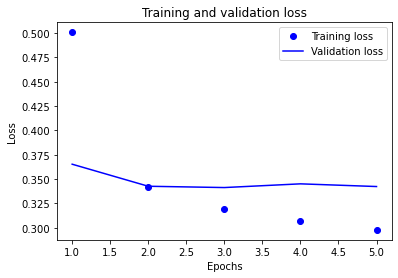

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6-1-2. RNN 모델의 Train, Validation의 Accuarcy 그래프

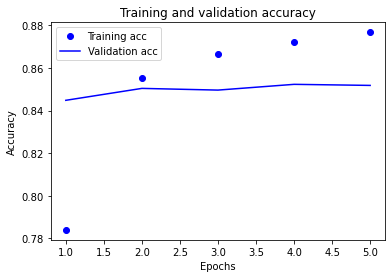

In [14]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## RNN 모델의 평가 결과
### 1) 학습과 평가 모두 정확도 약 85%
### 2) epoch 변화에 따른 정확도는 2를 초과하자 Train과 Validation이 많이 벌어지는 경향 확인
### >> epoch=2가 최적으로 판단됨.

## 4-2. 두 번째 모델 구성: 1D-CNN
### 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식
### CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습속도도 훨씬 빠르게 진행된다는 장점

In [15]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

## 5-2. 1D-CNN 모델 훈련 및 평가

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 8s 29ms/step - loss: 0.4816 - accuracy: 0.7527 - val_loss: 0.3448 - val_accuracy: 0.8494
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3258 - accuracy: 0.8605 - val_loss: 0.3354 - val_accuracy: 0.8560
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2942 - accuracy: 0.8779 - val_loss: 0.3276 - val_accuracy: 0.8587
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2674 - accuracy: 0.8912 - val_loss: 0.3359 - val_accuracy: 0.8556
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2374 - accuracy: 0.9062 - val_loss: 0.3471 - val_accuracy: 0.8542


### >>> 학습 결과: 검증 정확도 0.8542

In [17]:
# 학습이 끝난 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3611 - accuracy: 0.8479
[0.3610732853412628, 0.84787517786026]


### >>> 평가 결과: 정확도 0.8479

In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 6-2-1. 1D-CNN 모델의 Train, Validation의 loss 그래프

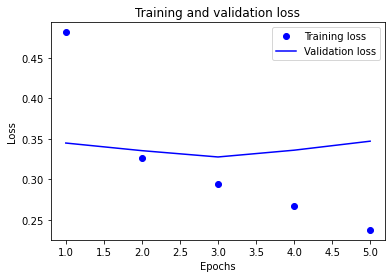

In [19]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6-2-2. 1D-CNN 모델의 Train, Validation의 Accuarcy 그래프

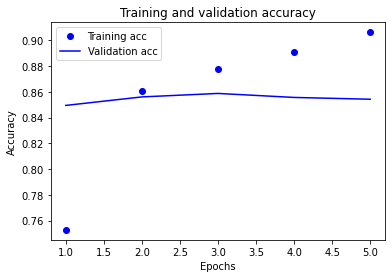

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1D-CNN 모델의 평가 결과
### 1) 학습, 평가 정확도: 약 85%
### 2) epoch변화에 따라 RNN과 마찬가지로 epoch가 2를 넘어가자 Train, Validation의 차이가 났다.
### 3) >> 정확도, epoch 변화 양상에 따른 정확도 변화가 RNN과 유사함

## 4-3. 세 번째 모델 구성: GlobalMaxPolling1D() 레이어 하나만 사용
###  전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

In [21]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5-3. GlobalMaxPolling1D() 모델 훈련 및 평가

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 4ms/step - loss: 0.5823 - accuracy: 0.7426 - val_loss: 0.4349 - val_accuracy: 0.8262
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3837 - accuracy: 0.8414 - val_loss: 0.3588 - val_accuracy: 0.8407
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3309 - accuracy: 0.8613 - val_loss: 0.3460 - val_accuracy: 0.8430
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3050 - accuracy: 0.8732 - val_loss: 0.3456 - val_accuracy: 0.8446
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.8822 - val_loss: 0.3495 - val_accuracy: 0.8468


### >>> 학습 결과: 검증 정확도 0.8468

In [23]:
# 학습이 끝난 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3661 - accuracy: 0.8435
[0.36612990498542786, 0.8434810638427734]


### >>> 평가 결과: 정확도 0.8435

In [24]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 6-3-1. GlobalMaxPolling1D() 모델의 Train, Validation의 loss 그래프

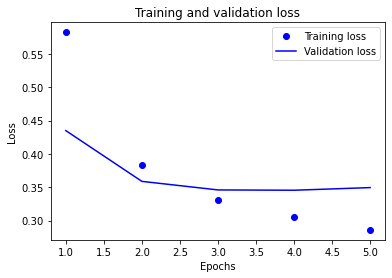

In [25]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6-3-2. GlobalMaxPolling1D() 모델의 Train, Validation의 Accuarcy 그래프

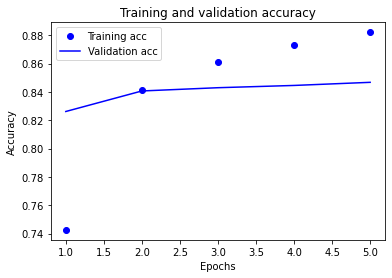

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1D-GlobalMaxPolling1D 모델의 평가 결과
### 1) 학습, 평가 정확도: 약 85%
### 2) epoch변화에 따라 RNN, 1D-CNN과 마찬가지로 epoch가 2를 넘어가자 Train, Validation의 차이가 났다.
### 3) >> 정확도, epoch 변화 양상에 따른 정확도 변화가 RNN, 1D-CNN과 유사함

## 3개 모델의 대한 평가 종합
### >>> epoch가 진행됨에 따라 Train의 loss는 감소하는 경향이지만 Validation의 loss는 epoch=3 이상이 되자 변함이 없다.
### >>> epoch를 변하기보다 모델의 파라미터를 변경할 필요 느낌
### >>> Accuary의 경우도 마찬가지 경향을 보임
### >>> 모델별 유의차 확인 못함

# 7. 학습된 Embedding 레이어 분석
## * 워드 임베딩(word embedding): 단어의 특성을 저차원 벡터값으로 표현할 수 있다. 머신러닝 기반 감성분석은 라벨링 등 비용이 많이 드는데 워드 임베딩은 비용을 절감시키고 정확도를 크게 향상시킬 수 있다.
## 학습했던 모델의 첫 번째 레이어가 Embedding레이어
## > 이 레이어는 사전의 단어의 개수 \* 워드벡터 사이즈만큼의 크기를 가진 학습 파라미터
## >> 학습이 잘 되었다면, Embedding레이어에 학습된 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것

In [27]:
embedding_layer = model.layers[0] # 학습한 모델의 첫 번째 레이어
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [28]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E04_Movie_Review_Emotion/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.11968963, -0.10236122, -0.08664621, -0.08978703,  0.08686492,
       -0.04234748, -0.12043402, -0.09870286, -0.01465059, -0.05866257,
       -0.08238919, -0.02107275, -0.08891781, -0.09782679, -0.00039076,
       -0.00041853], dtype=float32)

In [30]:
word_vectors.similar_by_word("재미")

[('2003', 0.8869756460189819),
 ('든데', 0.8779590129852295),
 ('스펙타클', 0.8653672933578491),
 ('도시락', 0.8649502992630005),
 ('장교', 0.8574231266975403),
 ('베리', 0.8569778203964233),
 ('부모', 0.8530154228210449),
 ('.....', 0.8512334227561951),
 ('눈앞', 0.8457478284835815),
 ('긴데', 0.8409601449966431)]

# 8. 한국어 Word2Vec 임베딩 활용해 성능개선

### 한국어 Word2Vec 모델 불러오기
#### 참고 - https://wikidocs.net/50739

In [31]:
import os
import gensim
word2vec_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E04_Movie_Review_Emotion/ko/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [48]:
print(word2vec_path)

/home/aiffel-dj40/1.AIFFEL_Study/Exploration/E04_Movie_Review_Emotion/ko/ko.bin


In [32]:
vector = word2vec['재미']
vector     # 무려 300dim의 워드 벡터입니다.

/home/aiffel-dj40/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [33]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("재미")

/home/aiffel-dj40/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('취미', 0.5857348442077637),
 ('유머', 0.514061450958252),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338053226471),
 ('공짜', 0.4960595965385437),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700761795043945),
 ('비애', 0.4836210608482361),
 ('관객', 0.4828645586967468),
 ('향수', 0.48233112692832947)]

In [67]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel-dj40/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj40/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [69]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [53]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [77]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
4256/4256 [==============================] - 81s 19ms/step - loss: 0.1186 - accuracy: 0.9577 - val_loss: 0.5525 - val_accuracy: 0.8350
Epoch 2/100
4256/4256 [==============================] - 68s 16ms/step - loss: 0.1006 - accuracy: 0.9650 - val_loss: 0.5704 - val_accuracy: 0.8400
Epoch 3/100
4256/4256 [==============================] - 69s 16ms/step - loss: 0.0898 - accuracy: 0.9692 - val_loss: 0.7076 - val_accuracy: 0.8301
Epoch 4/100
4256/4256 [==============================] - 67s 16ms/step - loss: 0.0780 - accuracy: 0.9734 - val_loss: 0.6319 - val_accuracy: 0.8364
Epoch 5/100
4256/4256 [==============================] - 70s 16ms/step - loss: 0.0680 - accuracy: 0.9766 - val_loss: 0.7095 - val_accuracy: 0.8361
Epoch 00005: early stopping


## >> 학습 결과: 검증 정확도 0.8361

In [78]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7225 - accuracy: 0.8297
[0.7225394248962402, 0.829688549041748]


## >> 평가 결과: 정확도 0.8297

In [79]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


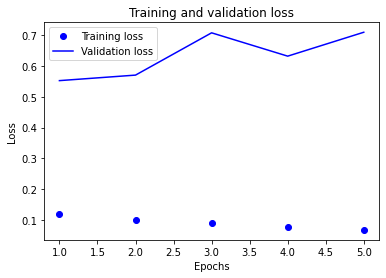

In [80]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

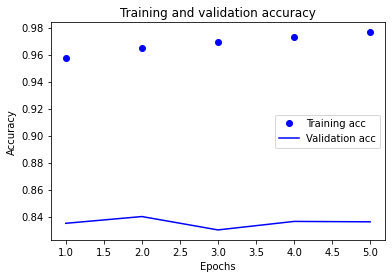

In [81]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 9. 루브릭 평가 및 소감

## 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
### >> RNN, 1D-CNN, GlobalMaxPooling1D 모델을 통해 진행했으며,
### >> 각 모델별로 Train, Validation의 loss, accuracy를 파악함

## 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
### >> 사전 학습된 모델을 활용해 임베딩 레이어 분석함
### >> gensim.models.Word2Vec.load 활용

## 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
### >> 한국어 Word2Vec을 활용해 학습 및 평가를 진행했으며 성능 향상은 없었다.

## 4. 소감
### - 자연처처리 분야는 다양하게 쓰이고 있는데 이번 노드를 통해 약간 맛을 본 것 같다.
### - 하지만 노드를 진행함에 있어 처음 마주하는 개념이 많아 뭐가 어떻게 되고 있는지 감을 못 잡아서 시간이 오래 걸렸다.
### - 큰 틀에서 어떻게 자연어가 처리되는지 이해했다.
### - 자연어 -> 중복제거 -> 결측치 제거 -> 불용어 제거 -> 토큰화 -> 인덱싱하고 데이터 split 후 모델 설계, 학습, 평가
### - 3가지 모델에 대해 성능 평가를 진행했는데 검증 정확도 측면에서는 큰 유의차가 없었는데
### 그 이유가 batch size라고 판단해서 한국어 Word2Vec을 활용할 때는 조정을 했다.
### - 또한 3가지 모델 진행 시 epoch가 3이하일 때 이미 학습이 잘 됐다고 판단해 EarlyStop을 활용해 진행해봤다.
### - 이번 노드를 진행하면서 참 어려움이 많았는데 팀원분들의 도움이 있어서 어려움을 많이 해결할 수 있었다.
### - 이후에도 나오는 자연어 처리 프로젝트는 좀 더 수월하게 진행할 수 있을 것이라 생각한다.